In [4]:
import pandas as pd
import numpy as np                                             # dense matrices
import matplotlib.pyplot as plt                                # plotting
from scipy.stats import multivariate_normal                    # multivariate Gaussian distribution
import copy                                                    # deep copies

# image handling library
from PIL import Image
from io import BytesIO

%matplotlib inline

### 1. Data Preprocessing

### 2. Implementing the EM algorithm for Gaussian mixture models (Build the model)

**Steps:**  
Create some synthetic data.  
Provide a log likelihood function for this model.  
Implement the EM algorithm.  
Visualize the progress of the parameters during the course of running EM.  
Visualize the convergence of the model.  

**Log likelihood**:
A function to calculate log likelihood for mixture of Gaussians. The log likelihood quantifies the probability of observing a given set of data under a particular setting of the parameters in our model.  
This is used to assess convergence of the EM alogrithm.

In [2]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

### 2.1 E-step: assign cluster responsibilities, given current parameters.

**Drawing from a Gaussian distribution.**  
SciPy provides a convenient function multivariate_normal.pdf that computes the likelihood of seeing a data point in a multivariate Gaussian distribution. The usage is

multivariate_normal.pdf([data point], mean=[mean vector], cov=[covariance matrix])

In [10]:
def compute_responsibilities(data, weights, means, covariances):
    '''E-step: compute responsibilities, given the current parameters'''
    num_data = len(data)
    num_clusters = len(means)
    resp = np.zeros((num_data, num_clusters))
    
    # Update resp matrix so that resp[i,k] is the responsibility of cluster k for data point i.
    # Hint: To compute likelihood of seeing data point i given cluster k, use multivariate_normal.pdf.
    for i in range(num_data):
        for k in range(num_clusters):
            resp[i, k] = weights[k] * multivariate_normal.pdf(data[i], means[k], covariances[k])
    
    # Add up responsibilities over each data point and normalize
    row_sums = resp.sum(axis = 1)[:, np.newaxis] 
    # np.newaxis is used to increase dimensions by 1 of the original array, but here nup.newaxis is used to reshape the data arry
    resp = resp / row_sums
    
    return resp

Checkpoint.

In [11]:
resp = compute_responsibilities(data = np.array([[1.,2.],[-1.,-2.]]), weights = np.array([0.3, 0.7]),
                                means = [np.array([0.,0.]), np.array([1.,1.])],
                                covariances = [np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])

if resp.shape == (2,2) and np.allclose(resp, np.array([[0.10512733, 0.89487267], [0.46468164, 0.53531836]])):
    print 'Checkpoint passed!'
else:
    print 'Check your code again.'

Checkpoint passed!


### 2.2 M-step: Update parameters, given current cluster responsibilities.

Once the cluster responsibilities are computed, we update the parameters (weights, means, and covariances) associated with the clusters.

**Computing soft counts.**  
Before updating the parameters, we first compute what is known as "soft counts". The soft count of a cluster is the sum of all cluster responsibilities for that cluster

In [15]:
def compute_soft_counts(resp):
    # Compute the total responsibility assigned to each cluster, which will be useful when 
    # implementing M-steps below. Here this is called N^{soft}
    counts = np.sum(resp, axis = 0)
    return counts

**Updating weights.**

In [20]:
def compute_weights(counts):
    num_clusters = len(counts)
    weights = [0.] * num_clusters
    
    for k in range(num_clusters):
        # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
        # HINT: compute # of data points by summing soft counts.
        weights[k] = counts[k] / float(counts.sum())

    return weights

Checkpoints.

In [21]:
resp = compute_responsibilities(data=np.array([[1.,2.],[-1.,-2.],[0,0]]), weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
weights = compute_weights(counts)

print counts
print weights

if np.allclose(weights, [0.27904865942515705, 0.720951340574843]):
    print 'Checkpoint passed!'
else:
    print 'Check your code again.'

[ 0.83714598  2.16285402]
[0.27904865942515705, 0.720951340574843]
Checkpoint passed!


**Updating means**: Weighted Average

In [30]:
def compute_means(data, resp, counts):
    num_clusters = len(counts)
    num_data = len(data)
    means = [np.zeros(len(data[0]))] * num_clusters
    
    for k in range(num_clusters):
        # Update means for cluster k using the M-step update rule for the mean variables.
        # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
        weighted_sum = 0.
        for i in range(num_data):
            weighted_sum += resp[i, k] * data[i]

        means[k] = weighted_sum / float(counts[k])

    return means

Checkpoint.

In [31]:
data_tmp = np.array([[1.,2.],[-1.,-2.]])
resp = compute_responsibilities(data=data_tmp, weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
means = compute_means(data_tmp, resp, counts)

if np.allclose(means, np.array([[-0.6310085, -1.262017], [0.25140299, 0.50280599]])):
    print 'Checkpoint passed!'
else:
    print 'Check your code again.'

Checkpoint passed!


**Updating covariances.**  
The covariance of each cluster is set to the weighted average of all outer products, weighted by the cluster responsibilities

In [33]:
def compute_covariances(data, resp, counts, means):
    num_clusters = len(counts)
    num_dim = len(data[0])
    num_data = len(data)
    covariances = [np.zeros((num_dim,num_dim))] * num_clusters
    
    for k in range(num_clusters):
        # Update covariances for cluster k using the M-step update rule for covariance variables.
        # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
        weighted_sum = np.zeros((num_dim, num_dim))
        for i in range(num_data):
            # Use np.outer on the data[i] and this cluster's mean (x-u)T(x-u)
            weighted_sum += resp[i, k] * np.outer(data[i] - means[k], data[i] - means[k])
        covariances[k] = weighted_sum / counts[k]

    return covariances

Checkpoint.

In [34]:
data_tmp = np.array([[1.,2.],[-1.,-2.]])
resp = compute_responsibilities(data=data_tmp, weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
means = compute_means(data_tmp, resp, counts)
covariances = compute_covariances(data_tmp, resp, counts, means)

if np.allclose(covariances[0], np.array([[0.60182827, 1.20365655], [1.20365655, 2.4073131]])) and \
    np.allclose(covariances[1], np.array([[ 0.93679654, 1.87359307], [1.87359307, 3.74718614]])):
    print 'Checkpoint passed!'
else:
    print 'Check your code again.'

Checkpoint passed!


**Final Implementation of EM alogrithm.**

In [35]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for it in range(maxiter):
        if it % 5 == 0:
            print("Iteration %s" % it)
        
        # E-step: compute responsibilities
        resp = compute_responsibilities(data, weights, means, covariances)

        # M-step
        # Compute the total responsibility assigned to each cluster, which will be useful when 
        # implementing M-steps below. In the lectures this is called N^{soft}
        counts = compute_soft_counts(resp)
        
        # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
        weights = compute_weights(counts)
        
        # Update means for cluster k using the M-step update rule for the mean variables.
        # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
        means = compute_means(data, resp, counts)
        
        # Update covariances for cluster k using the M-step update rule for covariance variables.
        # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
        covariances = compute_covariances(data, resp, counts, means)
                
        # Compute the loglikelihood at this iteration
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if it % 5 != 0:
        print("Iteration %s" % it)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

### 3. Testing the implementation on the simulated data

We will generate some observations from a mixture of Gaussians and then run our EM algorithm to discover the mixture components. We'll begin with a function to generate the data, and a quick plot to visualize its output for a 2-dimensional mixture of three Gaussians

Create a function to generate data from a mixture of Gaussians mode.

In [37]:
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.  
        k = np.random.choice(len(weights), 1, p = weights)[0]

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

In [38]:
# Model parameters
init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

Visualize our generated data.

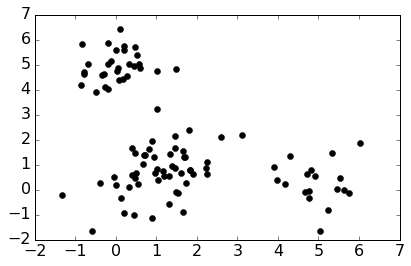

In [40]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Now we'll fit a mixture of Gaussians to this data using our implementation of the EM algorithm. As with k-means, it is important to ask how we obtain an initial configuration of mixing weights and component parameters. In this simple case, we'll take three random points to be the initial cluster means, use the empirical covariance of the data to be the initial covariance in each cluster (a clear overestimate), and set the initial mixing weights to be uniform across clusters.

In [41]:
np.random.seed(4)

# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3

# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


Like k-means, EM is prone to converging to a local optimum. In practice, you may want to run EM multiple times with different random initialization. We have omitted multiple restarts to keep the assignment reasonably short. For the purpose of this assignment, we assign a particular random seed (seed=4) to ensure consistent results among the students.



Our algorithm returns a dictionary with five elements:

'loglik': a record of the log likelihood at each iteration  
'resp': the final responsibility matrix  
'means': a list of K means  
'covs': a list of K covariance matrices  
'weights': the weights corresponding to each model component  

In [8]:
print results

NameError: name 'results' is not defined

**Plot progress of parameters.**  
One useful feature of testing our implementation on low-dimensional simulated data is that we can easily visualize the results.

We will use the following plot_contours function to visualize the Gaussian components over the data at three different points in the algorithm's execution:

At initialization (using initial_mu, initial_cov, and initial_weights)  
After running the algorithm to completion  
After just 12 iterations (using parameters estimates returned when setting maxiter=12)  

In [43]:
import matplotlib.mlab as mlab
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22
Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


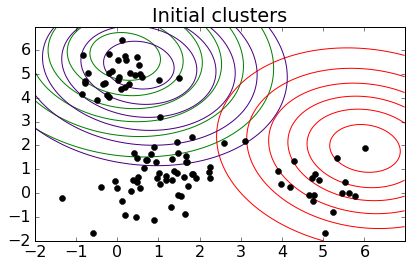

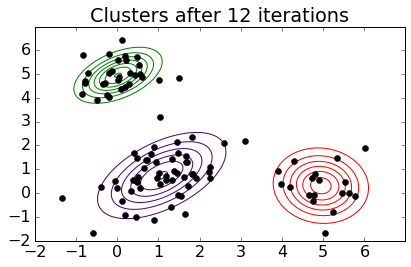

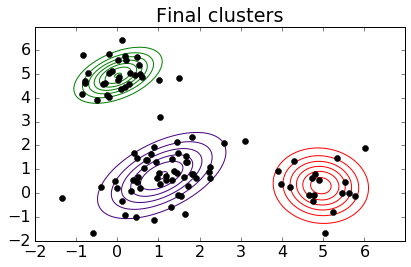

In [44]:
# Parameters after initialization
plot_contours(data, initial_means, initial_covs, 'Initial clusters')

# Parameters after 12 iterations
results = EM(data, initial_means, initial_covs, initial_weights)
plot_contours(data, results['means'], results['covs'], 'Clusters after 12 iterations')

# Parameters after running EM to convergence
results = EM(data, initial_means, initial_covs, initial_weights)
plot_contours(data, results['means'], results['covs'], 'Final clusters')

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


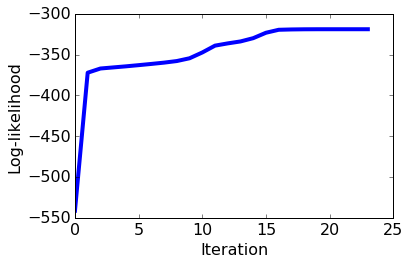

In [46]:
results = EM(data, initial_means, initial_covs, initial_weights)

loglikelihoods = results['loglik']

plt.plot(range(len(loglikelihoods)), loglikelihoods, linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

### 4. Fitting a Gaussian mixture model for image data

#### Generating dataset from original images.

You are free to experiment with other tools to generate 3-dimensional representation of images yourself. For each images, you should compute the average pixel value of each color channel and then divide the average by 256

In [53]:
# arr = 3D array of pixels, with dimensions (width, height, 3)
r, g, b = np.mean(arr[:,:,0]/256.0), np.mean(arr[:,:,1]/256.0), np.mean(arr[:,:,2]/256.0)

NameError: name 'arr' is not defined

**Initialization.**

In [ ]:
np.random.seed(1)

# Initalize parameters
init_means = [images['rgb'][x] for x in np.random.choice(len(images), 4, replace=False)]
cov = np.diag([images['red'].var(), images['green'].var(), images['blue'].var()])
init_covariances = [cov, cov, cov, cov]
init_weights = [1/4., 1/4., 1/4., 1/4.]

# Convert rgb data to numpy arrays
img_data = [np.array(i) for i in images['rgb']]  

# Run our EM algorithm on the image data using the above initializations. 
# This should converge in about 125 iterations
out = EM(img_data, init_means, init_covariances, init_weights)

The following sections will evaluate the results by asking the following questions:  
  
Convergence: How did the log likelihood change across iterations? Did the algorithm achieve convergence?  
Uncertainty: How did cluster assignment and uncertainty evolve?  
Interpretability: Can we view some example images from each cluster? Do these clusters correspond to known image categories?  

**Evaluating convergence.**

In [55]:
ll = out['loglik']
plt.plot(range(len(ll)),ll,linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

NameError: name 'out' is not defined

In [ ]:
plt.figure()
plt.plot(range(3,len(ll)),ll[3:],linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

**Evaluating uncertainty.**

In [56]:
import colorsys
def plot_responsibilities_in_RB(img, resp, title):
    N, K = resp.shape
    
    HSV_tuples = [(x*1.0/K, 0.5, 0.9) for x in range(K)]
    RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
    
    R = img['red']
    B = img['blue']
    resp_by_img_int = [[resp[n][k] for k in range(K)] for n in range(N)]
    cols = [tuple(np.dot(resp_by_img_int[n], np.array(RGB_tuples))) for n in range(N)]

    plt.figure()
    for n in range(len(R)):
        plt.plot(R[n], B[n], 'o', c=cols[n])
    plt.title(title)
    plt.xlabel('R value')
    plt.ylabel('B value')
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

In [ ]:
N, K = out['resp'].shape
random_resp = np.random.dirichlet(np.ones(K), N)
plot_responsibilities_in_RB(images, random_resp, 'Random responsibilities')

In [ ]:
out = EM(img_data, init_means, init_covariances, init_weights, maxiter=1)
plot_responsibilities_in_RB(images, out['resp'], 'After 1 iteration')

In [ ]:
out = EM(img_data, init_means, init_covariances, init_weights, maxiter=20)
plot_responsibilities_in_RB(images, out['resp'], 'After 20 iterations')

In [ ]:
weights = out['weights']
means = out['means']
covariances = out['covs']
rgb = images['rgb']
N = len(images) # number of images
K = len(means) # number of clusters

assignments = [0]*N
probs = [0]*N

for i in range(N):
    # Compute the score of data point i under each Gaussian component:
    p = np.zeros(K)
    for k in range(K):
        p[k] = weights[k]*multivariate_normal.pdf(rgb[i], mean=means[k], cov=covariances[k])
        
    # Compute assignments of each data point to a given cluster based on the above scores:
    assignments[i] = np.argmax(p)
    
    # For data point i, store the corresponding score under this cluster assignment:
    probs[i] = np.max(p)

assignments = n.array({'assignments':assignments, 'probs':probs, 'image': images['image']})

In [ ]:
def get_top_images(assignments, cluster, k=5):
    # YOUR CODE HERE
    images_in_cluster = ...
    top_images = images_in_cluster.topk('probs', k)
    return top_images['image']

In [ ]:
def display_images(images):
    from IPython.display import display
    
    for image in images:
        display(Image.open(BytesIO(image._image_data)))

def save_images(images, prefix):
    for i, image in enumerate(images):
        Image.open(BytesIO(image._image_data)).save(prefix % i)

In [ ]:
for component_id in range(4):
    print 'Component {0:d}'.format(component_id)
    images = get_top_images(assignments, component_id)
    display_images(images)
    #save_images(images, 'component_{0:d}_%d.jpg'.format(component_id))
    print '\n'